Prepare a prediction model for profit of 50_startups data.
Do transformations for getting better predictions of profit and
make a table containing R^2 value for each prepared model.

R&D Spend -- Research and devolop spend in the past few years<br>
Administration -- spend on administration in the past few years<br>
Marketing Spend -- spend on Marketing in the past few years<br>
State -- states from which data is collected<br>
Profit  -- profit of each state in the past few years<br>

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm


In [160]:
#Load the data
data = pd.read_csv("50_startups.csv")
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [161]:
#Drop & Rename
data1 = data.rename(mapper={"R&D Spend":"RDS","Administration":"ADS","Marketing Spend":"MKRTS"},axis=1)
data1.drop(columns="State",inplace=True)
data1.head()

,RDS,ADS,MKRTS,Profit
0,165349.20,136897.80,471784.10,192261.83
1,162597.70,151377.59,443898.53,191792.06
2,153441.51,101145.55,407934.54,191050.39
3,144372.41,118671.85,383199.62,182901.99
4,142107.34,91391.77,366168.42,166187.94


In [162]:
#check rows & columns 
data1.shape

(50, 4)

In [163]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RDS     50 non-null     float64
 1   ADS     50 non-null     float64
 2   MKRTS   50 non-null     float64
 3   Profit  50 non-null     float64
dtypes: float64(4)
memory usage: 1.7 KB


In [164]:
#Check duplicates
data1[data1.duplicated()].shape

(0, 4)

<AxesSubplot:>

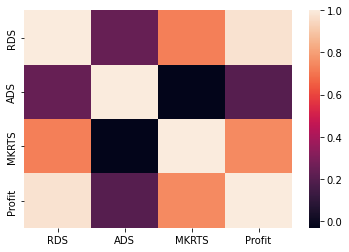

In [165]:
# Check for correlation
sns.heatmap(data1.corr())

In [166]:
def Normalize(data):
    x = (data-data.min())/(data.max()-data.min())
    return x

In [167]:
data1 = Normalize(data1)

In [168]:
data1.corr()

,RDS,ADS,MKRTS,Profit
RDS,1.000000,0.241955,0.724248,0.972900
ADS,0.241955,1.000000,-0.032154,0.200717
MKRTS,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


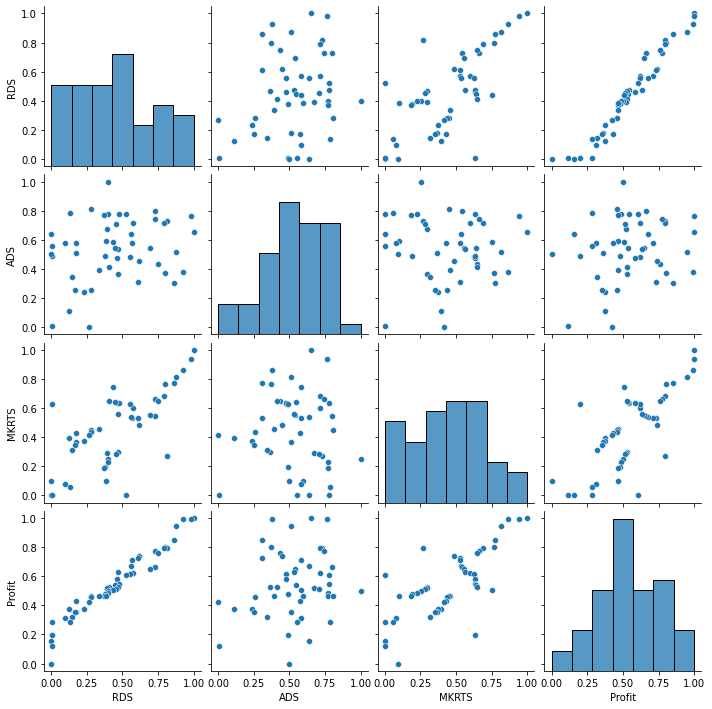

In [169]:
sns.pairplot(data1)

Looks Marketing spend ad R&D spend are correlated

# Creating Model from StatsModels

In [170]:
model1 = ols(formula="Profit~RDS+MKRTS+ADS",data=data1)
model1 = model1.fit()

In [171]:
print(f"Rsquared: {model1.rsquared}\nRsquared_adjusted:{model1.rsquared_adj}")

Rsquared: 0.9507459940683246
Rsquared_adjusted:0.9475337762901719


In [172]:
model1.pvalues

Intercept    4.508627e-10
RDS          2.634968e-22
MKRTS        1.047168e-01
ADS          6.017551e-01
dtype: float64

# Calculating VIF (Measeure Multi colinearity) 
### Vif should be low as possible (<5)

In [173]:
data1.head()

,RDS,ADS,MKRTS,Profit
0,1.000000,0.651744,1.000000,1.000000
1,0.983359,0.761972,0.940893,0.997355
2,0.927985,0.379579,0.864664,0.993178
3,0.873136,0.512998,0.812235,0.947292
4,0.859438,0.305328,0.776136,0.853171


In [174]:
model_rd = ols(formula="RDS~MKRTS+ADS",data=data1).fit().rsquared
vif_rd = 1/(1-model_rd)
model_ads = ols(formula="ADS~RDS+MKRTS",data=data1).fit().rsquared
vif_ads = 1/(1-model_ads)
model_mkrts = ols(formula="MKRTS~ADS+RDS",data=data1).fit().rsquared
vif_mkrts = 1/(1-model_mkrts)

In [175]:
pd.DataFrame({"Features":["Rd","ADS","MKRTS"],"VIF":[vif_rd,vif_ads,vif_mkrts]})

,Features,VIF
0,Rd,2.468903
1,ADS,1.175091
2,MKRTS,2.326773


ALL VIF are below 5


# Residual Analysis

1. Test for Normality of Residuals

C:\Users\AkashMY\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


Text(0.5, 1.0, 'Normal Q-Q plot of residuals')

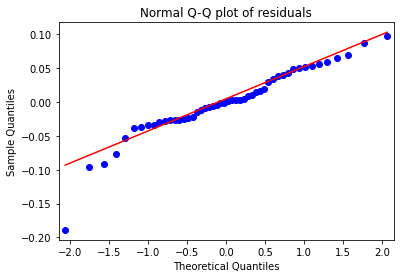

In [176]:
qqplot = sm.qqplot(model1.resid,line="q")
plt.title("Normal Q-Q plot of residuals")


In [177]:
np.where(model1.resid< -0.15)

(array([49], dtype=int64),)

2. Residual for Homoscedasticity (There should not be any patterns)<br>
(checking is there any relationship between Predicted values and actual values)

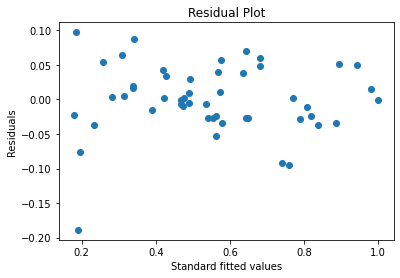

In [178]:
plt.title("Residual Plot")
plt.xlabel("Standard fitted values")
plt.ylabel("Residuals")
plt.scatter(x=model1.fittedvalues,y=model1.resid)

3. Residual vs Regressor Partial Regression plots

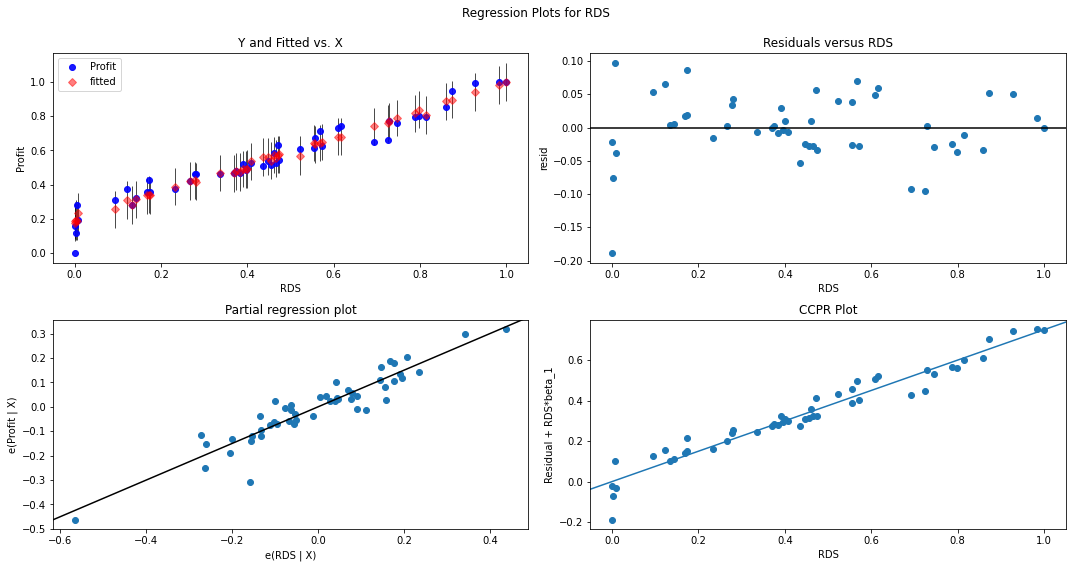

In [179]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1,"RDS",fig=fig)

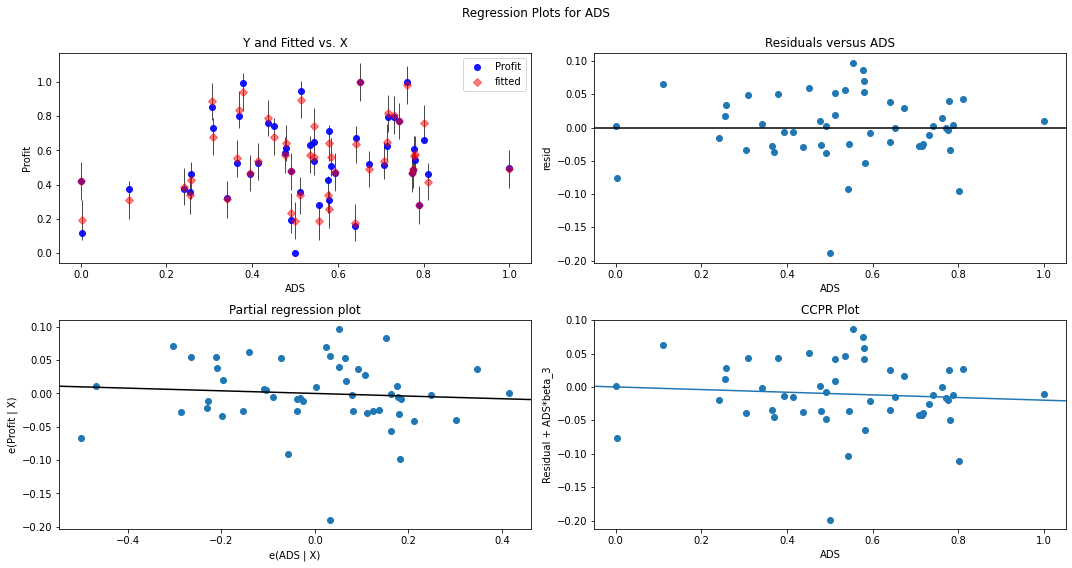

In [180]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1,"ADS",fig=fig)

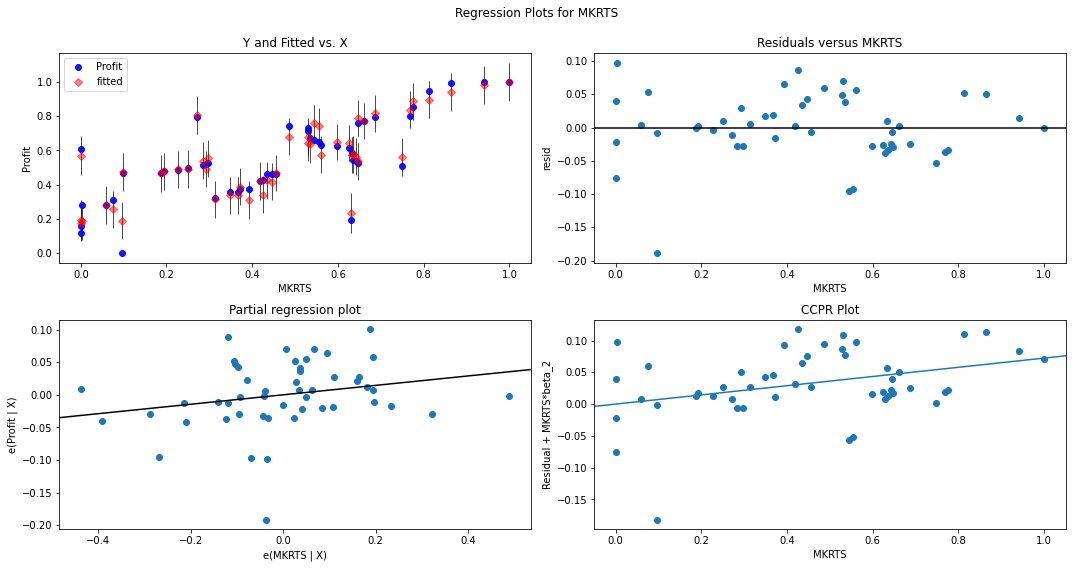

In [189]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1,"MKRTS",fig=fig)

# Creatingf model Using SKlearn

In [181]:
X = data1.drop(columns="Profit")
X.head()

,RDS,ADS,MKRTS
0,1.000000,0.651744,1.000000
1,0.983359,0.761972,0.940893
2,0.927985,0.379579,0.864664
3,0.873136,0.512998,0.812235
4,0.859438,0.305328,0.776136


In [182]:
y = data1.Profit
y.head()

0    1.000000
1    0.997355
2    0.993178
3    0.947292
4    0.853171
Name: Profit, dtype: float64

In [183]:
#Split Train Test 
X_train,X_test,Y_train,Y_test = train_test_split(X,y)

In [184]:
#Creating Model
model_sk1 = LinearRegression().fit(X_train,Y_train)

In [185]:
# Coeficients
model_sk1.coef_


array([ 0.75209814, -0.02767174,  0.07687762])

In [186]:
# Intercept
model_sk1.intercept_

0.18962990492328435

In [187]:
#Prediction
predict1 = model_sk1.predict(X_test)

In [188]:
#Testing Model with Test Data
df = pd.DataFrame(Y_test)
df["Y_predicted"] = predict1
df

,Profit,Y_predicted
33,0.462312,0.466115
10,0.740175,0.678034
26,0.512737,0.534551
12,0.714629,0.641267
20,0.584482,0.571958
28,0.498934,0.481649
15,0.648921,0.738176
34,0.461939,0.412735
23,0.529634,0.534993
35,0.460626,0.425303
